<a href="https://colab.research.google.com/github/annvorosh/GB/blob/StatMed/StatMed_L07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Урок 7. Анализ выживаемости


### Проведите анализ выживаемости пациентов с раком толстой кишки на приложенном к уроку датасете colon_dataset.tsv, используя код с занятия.
Попробуйте сравнить кривые выживаемости с различными ковариатами.
Задание выполняется на языке R и предоставляется в
Google Colab или PDF/html рендере Quarto.


## Установка библиотек

In [1]:
library(readr)

In [3]:
install.packages("ggplot2")
library(ggplot2)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [4]:

install.packages("tidyverse")
library(tidyverse)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ stringr   1.5.1
✔ forcats   1.0.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::%||%()   masks base::%||%()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [5]:
install.packages("survival")
library(survival)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [6]:
install.packages("ggsurvfit")
library(ggsurvfit)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘patchwork’




In [7]:
install.packages("gtsummary")
library(gtsummary)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘V8’, ‘reactR’, ‘labelled’, ‘bigD’, ‘bitops’, ‘htmlwidgets’, ‘juicyjuice’, ‘markdown’, ‘reactable’, ‘broom.helpers’, ‘gt’




In [8]:
install.packages("tidycmprsk")
library(tidycmprsk)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘cmprsk’, ‘hardhat’



Attaching package: ‘tidycmprsk’


The following object is masked from ‘package:gtsummary’:

    trial




In [9]:
install.packages("condSURV" )
library(condSURV)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘SparseM’, ‘MatrixModels’, ‘cubature’, ‘quadprog’, ‘quantreg’, ‘iterators’, ‘rngtools’, ‘np’, ‘doParallel’, ‘doRNG’, ‘foreach’




In [28]:
install.packages("survminer")
library(survminer)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘pbkrtest’, ‘lme4’, ‘corrplot’, ‘car’, ‘png’, ‘jpeg’, ‘ggrepel’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘polynom’, ‘rstatix’, ‘exactRankTests’, ‘mvtnorm’, ‘KMsurv’, ‘zoo’, ‘km.ci’, ‘xtable’, ‘gridtext’, ‘ggpubr’, ‘gridExtra’, ‘maxstat’, ‘survMisc’, ‘ggtext’


Loading required package: ggpubr


Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma




## Загрузка данных

In [10]:
# Загрузка данных
colon_data <- read_tsv("colon_dataset.tsv")

Rows: 1858 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): rx
dbl (15): id, study, sex, age, obstruct, perfor, adhere, nodes, status, diff...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [12]:
colon_df <- colon_data %>%
  as_tibble () %>%
  mutate(etype = recode (etype, '1' = 0, '2' = 1))



### Описание данных

| Столбец | Описание |
|---------|----------|
| `id` | Идентификатор пациента |
| `study` | Лечение: Observation, Lev(amisole), Lev(amisole)+5-FU |
| `sex` | Пол: 1=мужской |
| `age` | Возраст в годах |
| `obstruct` | Обструкция толстой кишки опухолью |
| `perfor` | Перфорация толстой кишки |
| `adhere` | Прилегание к близлежащим органам |
| `nodes` | Количество лимфатических узлов с обнаруженным раком |
| `time` | Время до события или цензуры в днях |
| `status` | Статус цензуры |
| `differ` | Дифференциация опухоли: 1=хорошо, 2=средне, 3=плохо |
| `extent` | Степень местного распространения: 1=подслизистая, 2=мышца, 3=сероза, 4=сопредельные структуры |
| `surg` | Время от операции до регистрации: 0=короткое, 1=длинное |
| `node4` | Больше 4 положительных лимфатических узлов |
| `etype` | Тип события: 1=рецидив, 2=смерть |


In [13]:
head(colon_df)
levels(colon_df$rx)

id,study,rx,sex,age,obstruct,perfor,adhere,nodes,status,differ,extent,surg,node4,time,etype
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,Lev+5FU,1,43,0,0,0,5,1,2,3,0,1,1521,1
1,1,Lev+5FU,1,43,0,0,0,5,1,2,3,0,1,968,0
2,1,Lev+5FU,1,63,0,0,0,1,0,2,3,0,0,3087,1
2,1,Lev+5FU,1,63,0,0,0,1,0,2,3,0,0,3087,0
3,1,Obs,0,71,0,0,1,7,1,2,2,0,1,963,1
3,1,Obs,0,71,0,0,1,7,1,2,2,0,1,542,0


NULL

## Обзор данных

Проверим структуру данных и основные статистики:

In [14]:
glimpse(colon_df)

Rows: 1,858
Columns: 16
$ id       <dbl> 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10,…
$ study    <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ rx       <chr> "Lev+5FU", "Lev+5FU", "Lev+5FU", "Lev+5FU", "Obs", "Obs", "Le…
$ sex      <dbl> 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0…
$ age      <dbl> 43, 43, 63, 63, 71, 71, 66, 66, 69, 69, 57, 57, 77, 77, 54, 5…
$ obstruct <dbl> 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ perfor   <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ adhere   <dbl> 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1…
$ nodes    <dbl> 5, 5, 1, 1, 7, 7, 6, 6, 22, 22, 9, 9, 5, 5, 1, 1, 2, 2, 1, 1,…
$ status   <dbl> 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0…
$ differ   <dbl> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2…
$ extent   <dbl> 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3…
$ surg     <dbl>

In [17]:
levels(factor(rep(c(1, 0), 929) == colon_df$etype)) #проверка, что каждый пациент содержит две метки в etype

[1] "TRUE"


Дальнейший анализ построен на предположении, что status == 1 означает возникновение рецидива опухоли. У данных пациентов etype == 1 - время возникновения опухоли, etype == 2 - время летального исхода. У людей со status == 1 оба времени - летальный исход.


### Разделим датасет

In [21]:
colon_df1 <- colon_df %>% #фрейм содержит время наступления рецидива или выбывания по причине смерти
  filter(etype == 0)
head(colon_df1)

id,study,rx,sex,age,obstruct,perfor,adhere,nodes,status,differ,extent,surg,node4,time,etype
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,Lev+5FU,1,43,0,0,0,5,1,2,3,0,1,968,0
2,1,Lev+5FU,1,63,0,0,0,1,0,2,3,0,0,3087,0
3,1,Obs,0,71,0,0,1,7,1,2,2,0,1,542,0
4,1,Lev+5FU,0,66,1,0,0,6,1,2,3,1,1,245,0
5,1,Obs,1,69,0,0,0,22,1,2,3,1,1,523,0
6,1,Lev+5FU,0,57,0,0,0,9,1,2,3,0,1,904,0


In [22]:
colon_df2 <- colon_df %>% #фрейм содержит время наступления летального исхода
  filter(etype == 1)
head(colon_df2)

id,study,rx,sex,age,obstruct,perfor,adhere,nodes,status,differ,extent,surg,node4,time,etype
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,Lev+5FU,1,43,0,0,0,5,1,2,3,0,1,1521,1
2,1,Lev+5FU,1,63,0,0,0,1,0,2,3,0,0,3087,1
3,1,Obs,0,71,0,0,1,7,1,2,2,0,1,963,1
4,1,Lev+5FU,0,66,1,0,0,6,1,2,3,1,1,293,1
5,1,Obs,1,69,0,0,0,22,1,2,3,1,1,659,1
6,1,Lev+5FU,0,57,0,0,0,9,1,2,3,0,1,1767,1


#### Среди людей с рецидивом новообразования летальность выше, чем среди пациентов без рецидива

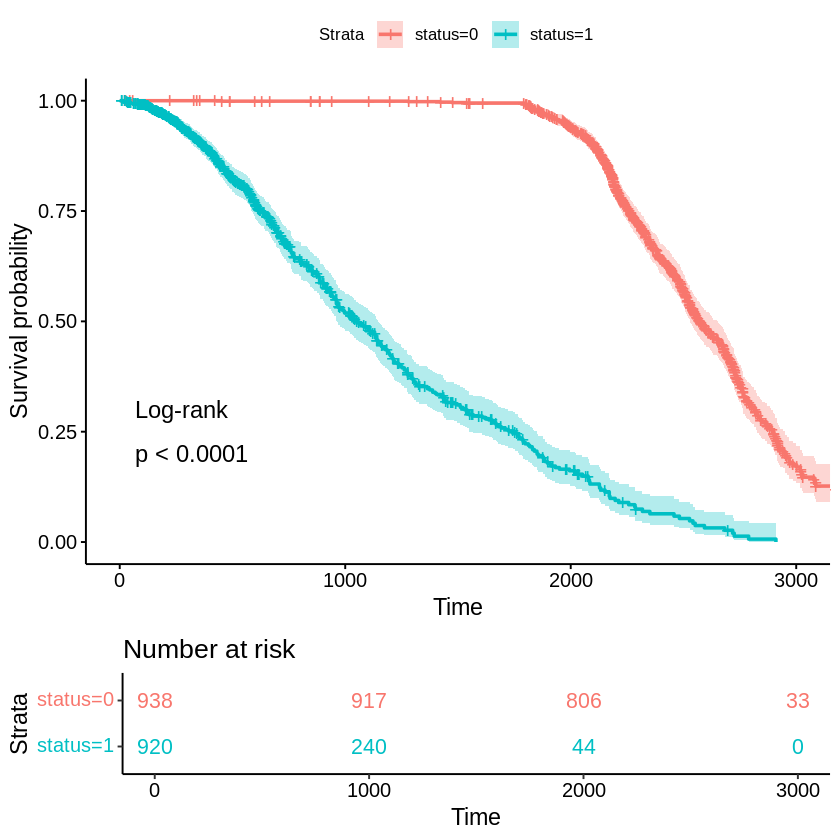

In [30]:
surv_fit <- survfit(Surv(time, etype) ~ status, data = colon_df)

survminer::ggsurvplot(surv_fit,
                      pval = TRUE,
                      pval.method = TRUE,
                      conf.int = TRUE,
                      risk.table = TRUE,
                      risk.table.col = "strata")

Кривая Каплана-Мейера: График показывает вероятность выживания (ось Y) в зависимости от времени (ось X).

Наблюдения:
- Пациенты с рецидивом новообразования (голубая линия) имеют значительно более низкую вероятность выживания по сравнению с пациентами без рецидива (красная линия).
- Вероятность выживания для пациентов с рецидивом новообразования резко снижается в течение первых 1000 дней и продолжает снижаться по мере увеличения времени.
- Пациенты без рецидива новообразования показывают высокую вероятность выживания на протяжении большей части периода наблюдения, с более резким снижением только после 2000 дней.

Среди пациентов с рецидивом новообразования летальность значительно выше, чем среди пациентов без рецидива.

#### Рассмотрим выживаемость пациентов в зависимоти от пола

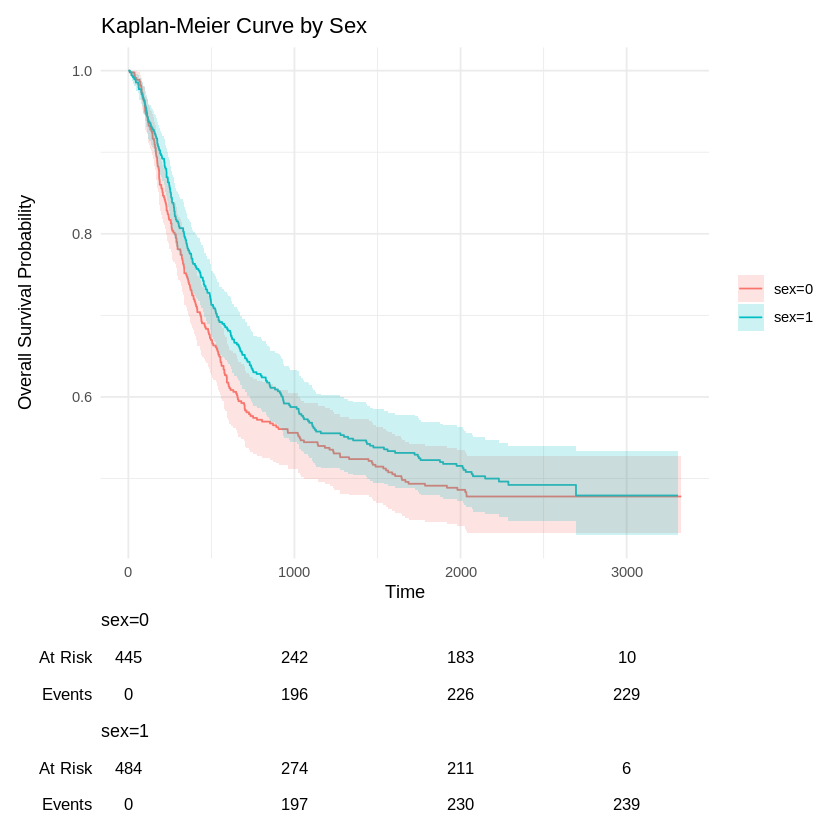

In [37]:
# Создание объектов выживаемости по полу
surv_fit_sex <- survfit(Surv(time, status) ~ sex, data = colon_df1)

# Визуализация кривой Каплана-Мейера по полу
km_plot_sex <- ggsurvfit(surv_fit_sex) +
  labs(
    title = "Kaplan-Meier Curve by Sex",
    x = "Time",
    y = "Overall Survival Probability"
  ) +
  add_confidence_interval() +
  add_risktable() +
  theme_minimal()

km_plot_sex


Анализ показывает, что, в целом, выживаемость мужчин и женщин схожа, без значительных различий между ними на протяжении всего периода наблюдения. Вероятность выживания постепенно снижается для обеих групп, с заметным снижением около 1000 дней и далее. Доверительные интервалы также указывают на аналогичные уровни неопределённости для обоих полов.


In [38]:
# Проведем лог-ранговый тест для проверки статистической значимости различий в кривых выживаемости по полу:
log_rank_test <- survdiff(Surv(time, status) ~ sex, data = colon_df1)

log_rank_test

Call:
survdiff(formula = Surv(time, status) ~ sex, data = colon_df1)

        N Observed Expected (O-E)^2/E (O-E)^2/V
sex=0 445      229      219     0.433     0.815
sex=1 484      239      249     0.382     0.815

 Chisq= 0.8  on 1 degrees of freedom, p= 0.4 

Значение p = 0.4 указывает на то, что нет статистически значимого различия в кривых выживаемости для мужчин и женщин.
Это подтверждает визуальный анализ кривых Каплана-Мейера, которые показывают, что кривые выживаемости для обоих полов практически совпадают.

#### Терапия влияет на скорость рецидива опухоли

In [64]:
surv_fit2 <- survdiff(Surv(time, status) ~ rx, data = colon_df1)
surv_fit2

Call:
survdiff(formula = Surv(time, status) ~ rx, data = colon_df1)

             N Observed Expected (O-E)^2/E (O-E)^2/V
rx=Lev     310      172      149      3.69      5.41
rx=Lev+5FU 304      119      169     14.69     23.04
rx=Obs     315      177      151      4.62      6.82

 Chisq= 23.1  on 2 degrees of freedom, p= 1e-05 

Значение p = 1e-05 указывает на то, что есть статистически значимое различие в кривых выживаемости для различных типов лечения.

Комбинация левамизола и 5FU (Lev+5FU) показала наилучшие результаты выживаемости среди всех групп.

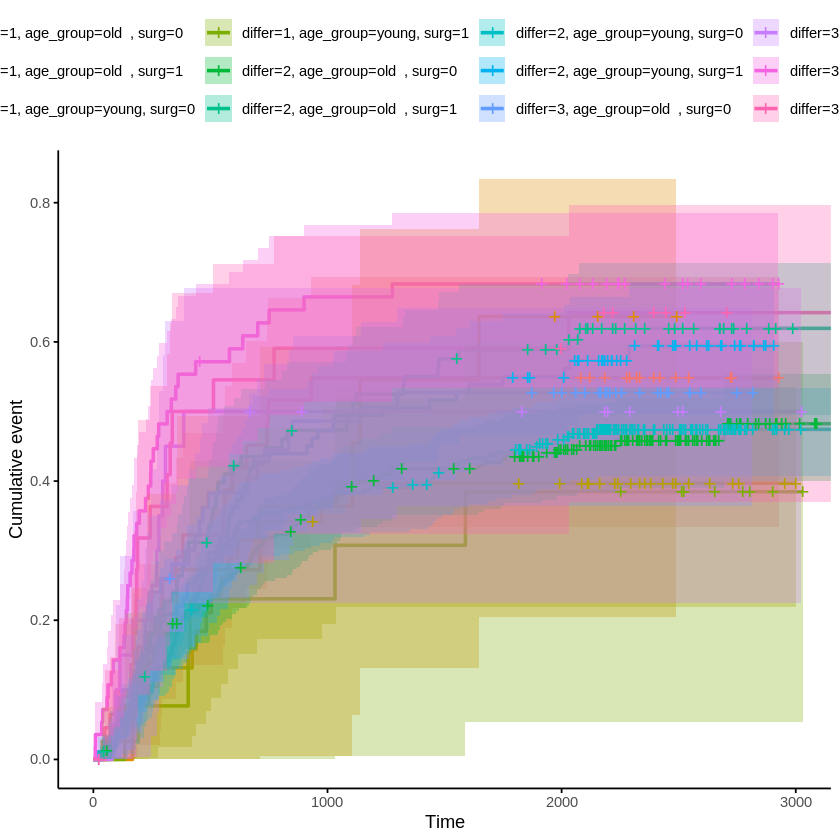

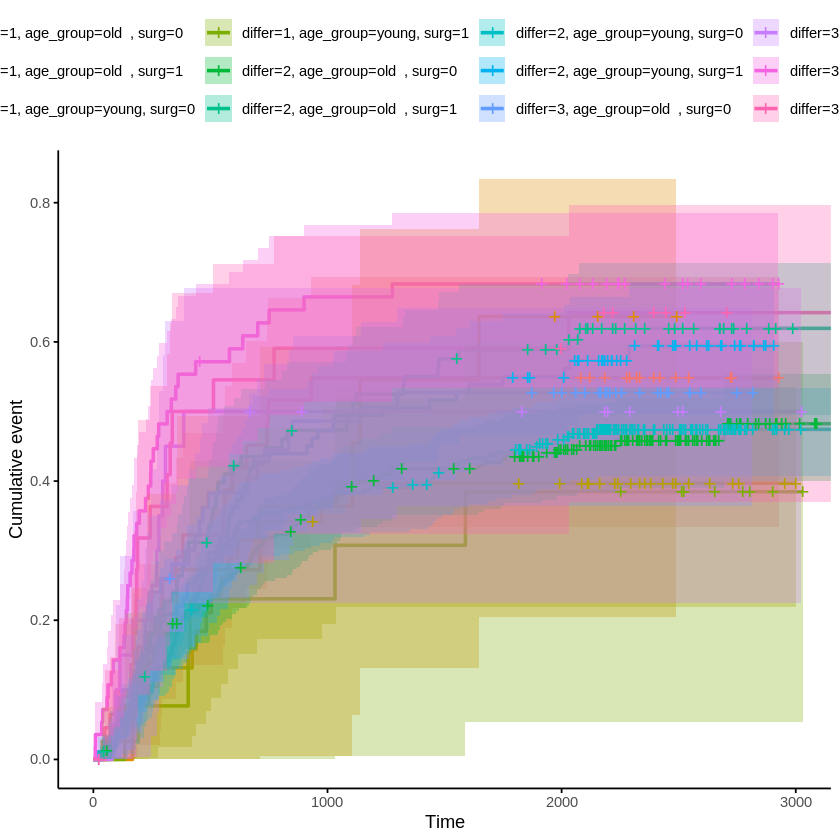

In [65]:
# Построение графика кривой событий (event)
survminer::ggsurvplot(surv_fit2,
           fun = "event",
           conf.int = TRUE,
           pval = TRUE,
           pval.method = TRUE,
           ggtheme = theme_classic())

# Построение графика накопленной опасности (cumulative hazard)
survminer::ggsurvplot(surv_fit2,
           fun = "cumhaz",
           conf.int = TRUE,
           pval = TRUE,
           pval.method = TRUE,
           ggtheme = theme_classic())


In [51]:
# Проведение анализа дисперсии (ANOVA)
aov_result <- aov(time ~ rx, data = colon_df1)


In [52]:
# Выполнение теста Хонеста Студента (HSD) Тьюки
tukey_result <- TukeyHSD(aov_result, conf.level = 0.95)

tukey_result

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = time ~ rx, data = colon_df1)

$rx
                  diff       lwr       upr     p adj
Lev+5FU-Lev  308.63593  121.4154  495.8565 0.0003427
Obs-Lev      -34.64583 -220.2086  150.9169 0.8995555
Obs-Lev+5FU -343.28176 -529.7652 -156.7983 0.0000510


Между группами Lev и Obs нет статистически значимой разницы во времени выживания (p = 0.9), что указывает на то, что эти два типа лечения имеют сходные результаты.

Между группами Lev и Lev+5FU существует статистически значимая разница во времени выживания (diff = 308.64, p < 0.001). Пациенты, получавшие лечение Lev+5FU, имели в среднем более длительное время выживания по сравнению с пациентами, получавшими только Lev.

Между группами Lev+5FU и Obs существует статистически значимая разница во времени выживания (diff = -343.28, p < 0.001). Пациенты, получавшие только Lev+5FU, имели в среднем более длительное время выживания по сравнению с пациентами, получавшими только Obs.

In [56]:
# Подгонка модели пропорциональных рисков Кокса
cox_model <- coxph(Surv(time, status) ~ rx, data = colon_df1)

# Сводка модели Кокса
summary(cox_model)


Call:
coxph(formula = Surv(time, status) ~ rx, data = colon_df1)

  n= 929, number of events= 468 

              coef exp(coef) se(coef)      z Pr(>|z|)    
rxLev+5FU -0.49697   0.60837  0.11931 -4.166 3.11e-05 ***
rxObs      0.01512   1.01524  0.10708  0.141    0.888    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

          exp(coef) exp(-coef) lower .95 upper .95
rxLev+5FU    0.6084      1.644    0.4815    0.7686
rxObs        1.0152      0.985    0.8230    1.2523

Concordance= 0.554  (se = 0.013 )
Likelihood ratio test= 24.34  on 2 df,   p=5e-06
Wald test            = 22.58  on 2 df,   p=1e-05
Score (logrank) test = 23.07  on 2 df,   p=1e-05


Модель Cox показывает, что лечение Lev+5FU связано с уменьшенным риском смерти по сравнению с лечением Obs, при этом последнее не оказывает статистически значимого влияния на выживаемость.